In [ ]:
!pip install torchmetrics

#**Imports**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm

import glob

#**Dataset**

# Load Dataset

In [ ]:
!cp '/content/drive/MyDrive/colab_projects/Recurrent Neural Network/UCI HAR Dataset.zip' /content

In [ ]:
!unzip '/content/UCI HAR Dataset.zip'

In [ ]:
def har_dataset(phase):
  x = []
  data_dir = f'/content/UCI HAR Dataset/{phase}/Inertial Signals/*'
  for file_dir in glob.glob(data_dir):
    x.append(np.loadtxt(file_dir))
  y = np.loadtxt(f'/content/UCI HAR Dataset/{phase}/y_{phase}.txt')
  x = torch.FloatTensor(x).permute(1, 2, 0)
  y = torch.LongTensor(y) - 1
  return x, y

In [ ]:
x_train, y_train = har_dataset('train')
x_test, y_test = har_dataset('test')

<ipython-input-11-cdf4b59997ec>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  x = torch.FloatTensor(x).permute(1, 2, 0)


# Convert to Tensor

In [ ]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

In [ ]:
train_set, test_set = random_split(train_set, (5000, x_train.shape[0]-5000))

# DataLoader

In [ ]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([64, 128, 9])
torch.Size([64])


# **Model**

In [ ]:
model = nn.Sequential(nn.RNN(input_size=9, hidden_size=32, num_layers=4,
                             nonlinearity='tanh', bias=True, batch_first=True, dropout=0.,
                             bidirectional=True),
                      nn.Linear(64, 6))

#**LSTM Model (from scratch)**

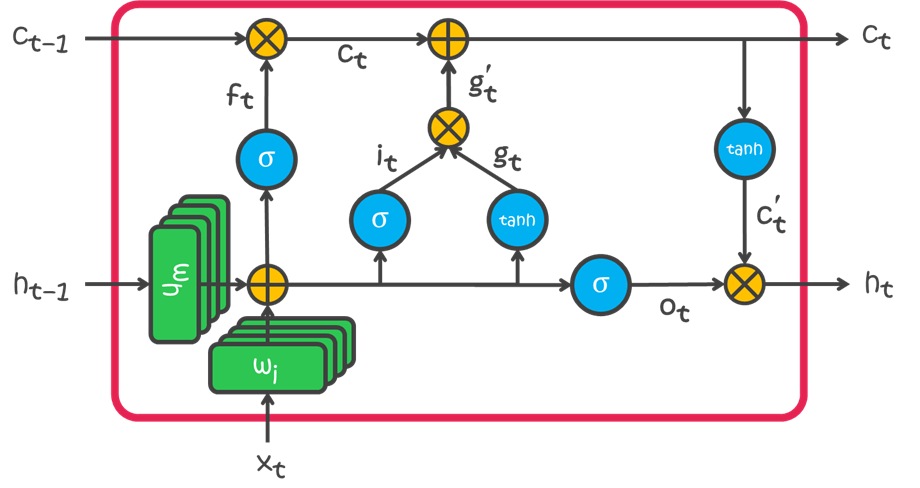

In [ ]:
class Gate(nn.Module):

  def __init__(self, hidden_size, af):
    super().__init__()
    self.fch = nn.LazyLinear(hidden_size)
    self.fcx = nn.LazyLinear(hidden_size)
    self.af = nn.Sigmoid() if af == 'sigmoid' else nn.Tanh()

  def forward(self, x, h):
    return self.af(self.fcx(x) + self.fch(h))

In [ ]:
class LSTM(nn.Module):

  def __init__(self, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.forget_gate = Gate(hidden_size, 'sigmoid')
    self.input_gate = Gate(hidden_size, 'sigmoid')
    self.output_gate = Gate(hidden_size, 'sigmoid')
    self.gate = Gate(hidden_size, 'tanh')

  def forward(self, x):
    ht = torch.zeros(self.hidden_size)
    ct = torch.zeros(self.hidden_size)
    output = []
    #
    for t in range(L): #BSxLxF
      xt = x[:, t, F]
      ft = self.forget_gate(xt, ht)
      ct = ct * ft
      #
      gt = self.gate(xt, ht)
      it = self.input_gate(xt, ht)
      ct = ct + gt * it
      #
      ot = self.output_gate(xt, ht)
      ht = ot * torch.tanh(ct)
      output.append(ht)
    return output, ht, ct

#**Device**

In PyTorch, .to(device) is used to move tensors or models to a specific device, which can be either a CPU or a GPU. This is necessary because operations involving tensors need to be performed on the same device. For example, if your model is on a GPU, your input tensors also need to be on the GPU to enable the model to perform computations on them.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#**Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#**Functions**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=6).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=6).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

#**Model**

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, RNN, input_size, hidden_size, num_layers, bidirectional, num_cls):
    super().__init__()
    self.rnn = RNN(input_size=input_size,
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      bidirectional=bidirectional,
                      batch_first=True)
    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    outputs, _ = self.rnn(x)
    y = self.fc(outputs) # out: many[:, -1, :]
    y = y.mean(dim=1)
    return y

In [ ]:
model = RNNModel(nn.LSTM, 9, 32, 1, False, 6)
model

RNNModel(
  (rnn): LSTM(9, 32, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
)

#**Setting Hyperparameters Efficiently**

## Check Forward Path

In [ ]:
model = RNNModel(nn.LSTM, 9, 128, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor(1.7805, grad_fn=<NllLossBackward0>)


## Check Backward Path

In [ ]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = RNNModel(nn.LSTM, 9, 128, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 25/25 [00:01<00:00, 16.15batch/s, accuracy=68.6, loss=0.737]


## Setting Learning Rate and Weight Decay

In [ ]:
num_epochs = 5

for lr in [0.08, 0.09, 0.1, 0.15, 0.2]:
  for wd in [1e-4, 1e-5, 0.]:
    model = RNNModel(nn.LSTM, 9, 128, 1, True, 6).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


LR=0.08, WD=0.0001


Epoch 4: 100%|██████████| 79/79 [00:32<00:00,  2.44batch/s, accuracy=50.8, loss=1.15]



LR=0.08, WD=1e-05


Epoch 4: 100%|██████████| 79/79 [00:31<00:00,  2.47batch/s, accuracy=51.2, loss=1.15]



LR=0.08, WD=0.0


Epoch 4: 100%|██████████| 79/79 [00:38<00:00,  2.07batch/s, accuracy=49, loss=1.19]



LR=0.09, WD=0.0001


Epoch 4: 100%|██████████| 79/79 [00:33<00:00,  2.38batch/s, accuracy=51.8, loss=1.1]



LR=0.09, WD=1e-05


Epoch 4: 100%|██████████| 79/79 [00:34<00:00,  2.30batch/s, accuracy=51.7, loss=1.12]



LR=0.09, WD=0.0


Epoch 4: 100%|██████████| 79/79 [00:34<00:00,  2.30batch/s, accuracy=52.4, loss=1.11]



LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 79/79 [00:34<00:00,  2.30batch/s, accuracy=52, loss=1.09]



LR=0.1, WD=1e-05


Epoch 4: 100%|██████████| 79/79 [00:34<00:00,  2.27batch/s, accuracy=50.3, loss=1.09]



LR=0.1, WD=0.0


Epoch 4: 100%|██████████| 79/79 [00:32<00:00,  2.43batch/s, accuracy=51.3, loss=1.09]



LR=0.15, WD=0.0001


Epoch 4: 100%|██████████| 79/79 [00:32<00:00,  2.42batch/s, accuracy=52.2, loss=1.05]



LR=0.15, WD=1e-05


Epoch 4: 100%|██████████| 79/79 [00:33<00:00,  2.35batch/s, accuracy=53.4, loss=1.04]



LR=0.15, WD=0.0


Epoch 4: 100%|██████████| 79/79 [00:32<00:00,  2.43batch/s, accuracy=52.9, loss=1.04]



LR=0.2, WD=0.0001


Epoch 4: 100%|██████████| 79/79 [00:32<00:00,  2.44batch/s, accuracy=53.6, loss=1.03]



LR=0.2, WD=1e-05


Epoch 4: 100%|██████████| 79/79 [00:38<00:00,  2.03batch/s, accuracy=57.4, loss=1.01]



LR=0.2, WD=0.0


Epoch 4: 100%|██████████| 79/79 [00:32<00:00,  2.42batch/s, accuracy=54.2, loss=1.02]

In [ ]:
model = RNNModel(nn.LSTM, 9, 128, 3, False, 6).to(device)

In [ ]:
lr = 0.02
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 80

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')

  if loss_valid < best_loss_valid:
    torch.save(model, 'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1

Epoch 0: 100%|██████████| 79/79 [00:54<00:00,  1.44batch/s, accuracy=18.3, loss=1.79]


Valid: Loss = 1.786, Acc = 0.1909
Model Saved!



Epoch 1: 100%|██████████| 79/79 [00:55<00:00,  1.41batch/s, accuracy=19.7, loss=1.78]


Valid: Loss = 1.777, Acc = 0.3835
Model Saved!



Epoch 2: 100%|██████████| 79/79 [00:55<00:00,  1.41batch/s, accuracy=32.4, loss=1.74]


Valid: Loss = 1.597, Acc = 0.4239
Model Saved!



Epoch 3: 100%|██████████| 79/79 [00:56<00:00,  1.40batch/s, accuracy=39.1, loss=1.36]


Valid: Loss = 1.285, Acc = 0.3784
Model Saved!



Epoch 4: 100%|██████████| 79/79 [00:54<00:00,  1.45batch/s, accuracy=44.3, loss=1.21]


Valid: Loss = 1.151, Acc = 0.4515
Model Saved!



Epoch 5: 100%|██████████| 79/79 [00:54<00:00,  1.45batch/s, accuracy=47.6, loss=1.12]


Valid: Loss = 1.115, Acc = 0.4864
Model Saved!



Epoch 6: 100%|██████████| 79/79 [00:57<00:00,  1.38batch/s, accuracy=49.1, loss=1.1]


Valid: Loss = 1.093, Acc = 0.4566
Model Saved!



Epoch 7: 100%|██████████| 79/79 [00:55<00:00,  1.41batch/s, accuracy=49.9, loss=1.07]


Valid: Loss = 1.078, Acc = 0.477
Model Saved!



Epoch 8: 100%|██████████| 79/79 [00:56<00:00,  1.40batch/s, accuracy=50.4, loss=1.08]


Valid: Loss = 1.079, Acc = 0.4928



Epoch 9: 100%|██████████| 79/79 [00:58<00:00,  1.36batch/s, accuracy=49.3, loss=1.07]


Valid: Loss = 1.015, Acc = 0.5234
Model Saved!



Epoch 10: 100%|██████████| 79/79 [00:56<00:00,  1.41batch/s, accuracy=52.5, loss=1.03]


Valid: Loss = 1.002, Acc = 0.5174
Model Saved!



Epoch 11: 100%|██████████| 79/79 [00:55<00:00,  1.43batch/s, accuracy=54.7, loss=0.99]


Valid: Loss = 0.9795, Acc = 0.5595
Model Saved!



Epoch 12: 100%|██████████| 79/79 [00:56<00:00,  1.39batch/s, accuracy=62, loss=0.864]


Valid: Loss = 0.8623, Acc = 0.591
Model Saved!



Epoch 13: 100%|██████████| 79/79 [00:55<00:00,  1.42batch/s, accuracy=65.8, loss=0.742]


Valid: Loss = 0.6985, Acc = 0.733
Model Saved!



Epoch 14: 100%|██████████| 79/79 [00:56<00:00,  1.41batch/s, accuracy=70.6, loss=0.664]


Valid: Loss = 0.5857, Acc = 0.7415
Model Saved!



Epoch 15: 100%|██████████| 79/79 [00:58<00:00,  1.36batch/s, accuracy=73.9, loss=0.598]


Valid: Loss = 0.5438, Acc = 0.7844
Model Saved!



Epoch 16: 100%|██████████| 79/79 [00:56<00:00,  1.41batch/s, accuracy=75.3, loss=0.578]


Valid: Loss = 0.5547, Acc = 0.7577



Epoch 17: 100%|██████████| 79/79 [00:57<00:00,  1.36batch/s, accuracy=75, loss=0.544]


Valid: Loss = 0.5418, Acc = 0.7304
Model Saved!



Epoch 18: 100%|██████████| 79/79 [00:54<00:00,  1.46batch/s, accuracy=76.5, loss=0.515]


Valid: Loss = 0.4703, Acc = 0.7823
Model Saved!



Epoch 19: 100%|██████████| 79/79 [00:54<00:00,  1.44batch/s, accuracy=79.1, loss=0.476]


Valid: Loss = 0.4424, Acc = 0.8265
Model Saved!



Epoch 20: 100%|██████████| 79/79 [00:56<00:00,  1.40batch/s, accuracy=78.8, loss=0.482]


Valid: Loss = 0.4426, Acc = 0.8027



Epoch 21: 100%|██████████| 79/79 [00:55<00:00,  1.41batch/s, accuracy=80.7, loss=0.438]


Valid: Loss = 0.4545, Acc = 0.7942



Epoch 22: 100%|██████████| 79/79 [00:56<00:00,  1.40batch/s, accuracy=82.2, loss=0.428]


Valid: Loss = 0.3857, Acc = 0.8274
Model Saved!



Epoch 23: 100%|██████████| 79/79 [00:58<00:00,  1.36batch/s, accuracy=82.1, loss=0.441]


Valid: Loss = 0.3903, Acc = 0.824



Epoch 24: 100%|██████████| 79/79 [00:55<00:00,  1.42batch/s, accuracy=85.4, loss=0.378]


Valid: Loss = 0.4659, Acc = 0.8448



Epoch 25: 100%|██████████| 79/79 [00:54<00:00,  1.44batch/s, accuracy=87.1, loss=0.351]


Valid: Loss = 0.3213, Acc = 0.8844
Model Saved!



Epoch 26: 100%|██████████| 79/79 [00:57<00:00,  1.38batch/s, accuracy=87.7, loss=0.341]


Valid: Loss = 0.3436, Acc = 0.8895



Epoch 27: 100%|██████████| 79/79 [00:56<00:00,  1.40batch/s, accuracy=88.3, loss=0.331]


Valid: Loss = 0.3126, Acc = 0.8754
Model Saved!



Epoch 28: 100%|██████████| 79/79 [00:56<00:00,  1.41batch/s, accuracy=88.6, loss=0.332]


Valid: Loss = 0.3356, Acc = 0.8682



Epoch 29: 100%|██████████| 79/79 [00:57<00:00,  1.36batch/s, accuracy=90.2, loss=0.292]


Valid: Loss = 0.2935, Acc = 0.8992
Model Saved!



Epoch 30: 100%|██████████| 79/79 [00:55<00:00,  1.43batch/s, accuracy=91.8, loss=0.262]


Valid: Loss = 0.25, Acc = 0.9128
Model Saved!



Epoch 31: 100%|██████████| 79/79 [00:54<00:00,  1.45batch/s, accuracy=91.3, loss=0.253]


Valid: Loss = 0.2413, Acc = 0.9082
Model Saved!



Epoch 32: 100%|██████████| 79/79 [00:54<00:00,  1.46batch/s, accuracy=91.5, loss=0.26]


Valid: Loss = 0.2387, Acc = 0.9137
Model Saved!



Epoch 33: 100%|██████████| 79/79 [00:55<00:00,  1.43batch/s, accuracy=92.1, loss=0.233]


Valid: Loss = 0.335, Acc = 0.872



Epoch 34: 100%|██████████| 79/79 [00:57<00:00,  1.37batch/s, accuracy=91.9, loss=0.242]


Valid: Loss = 0.1882, Acc = 0.9303
Model Saved!



Epoch 35: 100%|██████████| 79/79 [00:56<00:00,  1.41batch/s, accuracy=92.4, loss=0.221]


Valid: Loss = 0.2331, Acc = 0.9137



Epoch 36: 100%|██████████| 79/79 [00:56<00:00,  1.41batch/s, accuracy=92.8, loss=0.222]


Valid: Loss = 0.1932, Acc = 0.9252



Epoch 37: 100%|██████████| 79/79 [00:56<00:00,  1.39batch/s, accuracy=92.4, loss=0.218]


Valid: Loss = 0.1935, Acc = 0.9175



Epoch 38: 100%|██████████| 79/79 [00:54<00:00,  1.45batch/s, accuracy=92.4, loss=0.228]


Valid: Loss = 0.1834, Acc = 0.9392
Model Saved!



Epoch 39: 100%|██████████| 79/79 [00:54<00:00,  1.44batch/s, accuracy=93.2, loss=0.193]


Valid: Loss = 0.1968, Acc = 0.9396



Epoch 40: 100%|██████████| 79/79 [00:57<00:00,  1.37batch/s, accuracy=92, loss=0.229]


Valid: Loss = 0.2598, Acc = 0.9014



Epoch 41: 100%|██████████| 79/79 [00:55<00:00,  1.41batch/s, accuracy=92.7, loss=0.213]


Valid: Loss = 0.2231, Acc = 0.909



Epoch 42: 100%|██████████| 79/79 [00:55<00:00,  1.42batch/s, accuracy=93.1, loss=0.21]


Valid: Loss = 0.1759, Acc = 0.9345
Model Saved!



Epoch 43: 100%|██████████| 79/79 [00:56<00:00,  1.39batch/s, accuracy=93.5, loss=0.183]


Valid: Loss = 0.1724, Acc = 0.9384
Model Saved!



Epoch 44: 100%|██████████| 79/79 [00:54<00:00,  1.46batch/s, accuracy=93.6, loss=0.181]


Valid: Loss = 0.2088, Acc = 0.9162



Epoch 45: 100%|██████████| 79/79 [00:54<00:00,  1.46batch/s, accuracy=92.2, loss=0.208]


Valid: Loss = 0.2287, Acc = 0.9167



Epoch 46: 100%|██████████| 79/79 [00:56<00:00,  1.39batch/s, accuracy=93.2, loss=0.179]


Valid: Loss = 0.1517, Acc = 0.9481
Model Saved!



Epoch 47: 100%|██████████| 79/79 [00:55<00:00,  1.42batch/s, accuracy=93.1, loss=0.182]


Valid: Loss = 0.1998, Acc = 0.9188



Epoch 48: 100%|██████████| 79/79 [00:56<00:00,  1.40batch/s, accuracy=93.2, loss=0.197]


Valid: Loss = 0.191, Acc = 0.9247



Epoch 49: 100%|██████████| 79/79 [00:55<00:00,  1.41batch/s, accuracy=93.1, loss=0.181]


Valid: Loss = 0.1679, Acc = 0.9409



Epoch 50: 100%|██████████| 79/79 [00:54<00:00,  1.44batch/s, accuracy=94, loss=0.169]


Valid: Loss = 0.1541, Acc = 0.9413



Epoch 51: 100%|██████████| 79/79 [00:56<00:00,  1.40batch/s, accuracy=93.5, loss=0.184]


Valid: Loss = 0.1993, Acc = 0.9222



Epoch 52: 100%|██████████| 79/79 [00:54<00:00,  1.46batch/s, accuracy=94, loss=0.168]


Valid: Loss = 0.1909, Acc = 0.9269



Epoch 53: 100%|██████████| 79/79 [00:54<00:00,  1.46batch/s, accuracy=93.5, loss=0.177]


Valid: Loss = 0.1703, Acc = 0.9307



Epoch 54: 100%|██████████| 79/79 [00:57<00:00,  1.38batch/s, accuracy=93.8, loss=0.176]


Valid: Loss = 0.1544, Acc = 0.9358



Epoch 55: 100%|██████████| 79/79 [00:55<00:00,  1.42batch/s, accuracy=93, loss=0.191]


Valid: Loss = 0.1539, Acc = 0.946



Epoch 56: 100%|██████████| 79/79 [00:55<00:00,  1.42batch/s, accuracy=94.2, loss=0.159]


Valid: Loss = 0.1829, Acc = 0.9435



Epoch 57: 100%|██████████| 79/79 [00:57<00:00,  1.37batch/s, accuracy=93.5, loss=0.185]


Valid: Loss = 0.2615, Acc = 0.9099



Epoch 58: 100%|██████████| 79/79 [00:54<00:00,  1.46batch/s, accuracy=93.8, loss=0.166]


Valid: Loss = 0.151, Acc = 0.9371
Model Saved!



Epoch 59: 100%|██████████| 79/79 [00:54<00:00,  1.46batch/s, accuracy=94.2, loss=0.158]


Valid: Loss = 0.1755, Acc = 0.9307



Epoch 60: 100%|██████████| 79/79 [00:56<00:00,  1.41batch/s, accuracy=93.1, loss=0.183]


Valid: Loss = 0.1879, Acc = 0.9311



Epoch 61: 100%|██████████| 79/79 [00:55<00:00,  1.42batch/s, accuracy=93.8, loss=0.166]


Valid: Loss = 0.1613, Acc = 0.9447



Epoch 62: 100%|██████████| 79/79 [01:01<00:00,  1.29batch/s, accuracy=94.1, loss=0.152]


Valid: Loss = 0.1433, Acc = 0.9384
Model Saved!



Epoch 63: 100%|██████████| 79/79 [01:00<00:00,  1.31batch/s, accuracy=94.2, loss=0.156]


Valid: Loss = 0.1423, Acc = 0.9384
Model Saved!



Epoch 64: 100%|██████████| 79/79 [00:58<00:00,  1.35batch/s, accuracy=94.5, loss=0.153]


Valid: Loss = 0.1616, Acc = 0.9464



Epoch 65: 100%|██████████| 79/79 [00:59<00:00,  1.33batch/s, accuracy=94.3, loss=0.155]


Valid: Loss = 0.1694, Acc = 0.9328



Epoch 66: 100%|██████████| 79/79 [00:58<00:00,  1.34batch/s, accuracy=93.7, loss=0.175]


Valid: Loss = 0.1439, Acc = 0.9396



Epoch 67: 100%|██████████| 79/79 [00:58<00:00,  1.35batch/s, accuracy=94.3, loss=0.148]


Valid: Loss = 0.1626, Acc = 0.9366



Epoch 68: 100%|██████████| 79/79 [00:59<00:00,  1.33batch/s, accuracy=94.6, loss=0.151]


Valid: Loss = 0.2374, Acc = 0.9188



Epoch 69: 100%|██████████| 79/79 [00:54<00:00,  1.45batch/s, accuracy=94.2, loss=0.155]


Valid: Loss = 0.1417, Acc = 0.9413
Model Saved!



Epoch 70: 100%|██████████| 79/79 [00:54<00:00,  1.46batch/s, accuracy=94.9, loss=0.143]


Valid: Loss = 0.1349, Acc = 0.9511
Model Saved!



Epoch 71: 100%|██████████| 79/79 [00:55<00:00,  1.42batch/s, accuracy=94.8, loss=0.14]


Valid: Loss = 0.1736, Acc = 0.9281



Epoch 72: 100%|██████████| 79/79 [00:55<00:00,  1.42batch/s, accuracy=94.2, loss=0.156]


Valid: Loss = 0.16, Acc = 0.9439



Epoch 73: 100%|██████████| 79/79 [00:57<00:00,  1.37batch/s, accuracy=94.7, loss=0.142]


Valid: Loss = 0.1353, Acc = 0.9537



Epoch 74: 100%|██████████| 79/79 [00:55<00:00,  1.42batch/s, accuracy=94.4, loss=0.144]


Valid: Loss = 0.155, Acc = 0.9324



Epoch 75: 100%|██████████| 79/79 [00:55<00:00,  1.42batch/s, accuracy=94.3, loss=0.151]


Valid: Loss = 0.1503, Acc = 0.9413



Epoch 76: 100%|██████████| 79/79 [00:56<00:00,  1.39batch/s, accuracy=94.5, loss=0.142]


Valid: Loss = 0.1427, Acc = 0.9413



Epoch 77: 100%|██████████| 79/79 [00:53<00:00,  1.47batch/s, accuracy=95.2, loss=0.128]


Valid: Loss = 0.1271, Acc = 0.9532
Model Saved!



Epoch 78: 100%|██████████| 79/79 [00:54<00:00,  1.46batch/s, accuracy=94.8, loss=0.133]


Valid: Loss = 0.1214, Acc = 0.949
Model Saved!



Epoch 79: 100%|██████████| 79/79 [00:57<00:00,  1.38batch/s, accuracy=94.8, loss=0.134]


Valid: Loss = 0.1209, Acc = 0.9473
Model Saved!



# **Plot**

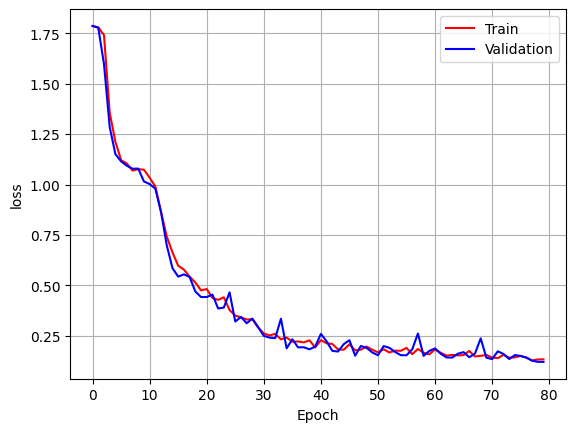

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

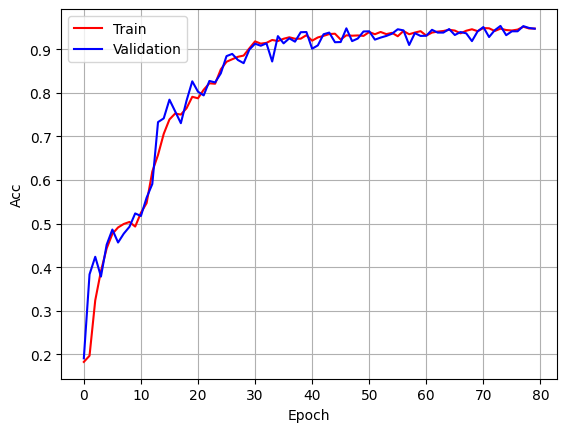

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()